In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import segmentation_models as sm
import tensorflow as tf
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


In [2]:
image_directory = '../voc_multi_semantic_seg_dataset/PNGImages/*'
mask_directory = '../voc_multi_semantic_seg_dataset/SegmentationClassPNG/*'
whu_image_directory = '../Satellite_dataset(global cities)/image/*'
whu_mask_directory = '../Satellite_dataset(global cities)/label/*'

In [3]:
# tf.config.run_functions_eagerly(True)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [6]:
image_names = glob.glob(image_directory)
image_names

['../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_13-57-46.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-00-47.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-00.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-04.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-09.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-21.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-28.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-38.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-42.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-50.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-57.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-02-02.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-02-47.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-1

In [7]:
mask_names = glob.glob(mask_directory)
mask_names

['../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_13-57-46.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-00-47.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-00.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-04.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-09.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-21.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-28.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-38.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-42.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-50.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-57.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-02-0

In [8]:
image_names.sort()
images = [cv2.imread(img) for img in image_names]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
image_dataset = np.array(images)

In [9]:
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)

In [10]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (124, 512, 512, 3)
Mask data shape is:  (124, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0  14  19  38  52  75  89 113 128]


In [11]:
mask_labels = np.unique(mask_dataset)
for mask in mask_dataset:
    for i, val in enumerate(mask_labels):
        mask[mask == val] = i
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1 2 3 4 5 6 7 8]


In [12]:
#binary segmentation
for mask in mask_dataset:
    mask[mask > 0] = 1.
    mask[mask == 0] = 0.
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1]


In [13]:
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
images1=preprocess_input1(image_dataset)
print(images1.shape)

(124, 512, 512, 3)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(images1, mask_dataset, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(93, 512, 512, 3)
(31, 512, 512, 3)


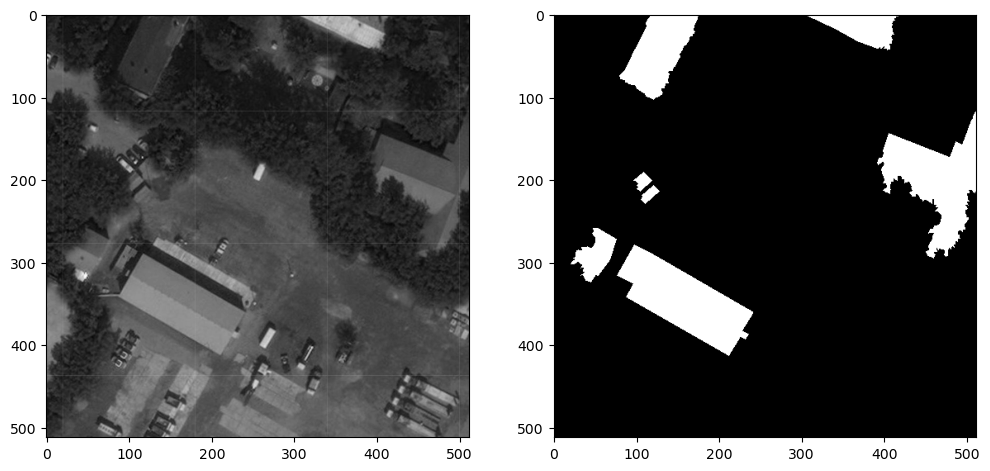

[0 1]


In [15]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number, :,:, 0], cmap='gray')
plt.show()
print(np.unique(y_train))

In [16]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

In [17]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

In [18]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [19]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

In [20]:
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

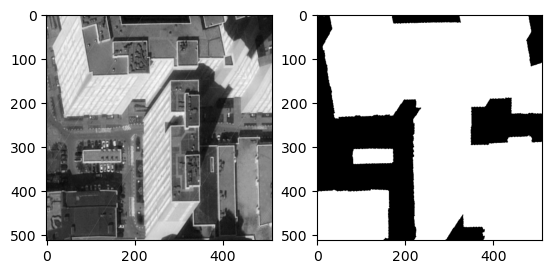

In [21]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [22]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [27]:
print(len(my_generator))

TypeError: object of type 'generator' has no len()

In [26]:
#Fit the model
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 1, validation_steps=len(X_train) // 1, epochs=100)
# history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=400, validation_steps=50, epochs=50)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/decoder_stage3_concat/concat' defined at (most recent call last):
    File "C:\Users\user\miniconda3\envs\tf\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\user\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\user\miniconda3\envs\tf\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\user\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\user\miniconda3\envs\tf\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_9492\3693814972.py", line 2, in <module>
      history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 40, validation_steps=len(X_train) // 40, epochs=100)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "C:\Users\user\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_1/decoder_stage3_concat/concat'
OOM when allocating tensor with shape[29,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node model_1/decoder_stage3_concat/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7405]

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

In [ ]:
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()